# The finite element method
We want to solve the ODE
$$\left\{\begin{eqnarray}
&&p(x)u - \frac{d}{dx}\left(q(x) \frac{du}{dx}\right) = r(x) \in \, ]0, L[\\
&&u(0) = c, \quad q(L)\frac{du}{dx}(L) = d
\end{eqnarray}\right.$$

The Finite Element Method solves this problem in several steps:
* Transform the differential equation into a weak formulation
* Describe the geometry as a mesh of elements
* Integrate the weak form on each element on a set of well chosen functions
* Solve an algebraic discrete linear problem

A first important ingredient is the choice of a numeric integration method to compute $\int f(x) dx$.

## Gaussian quadrature and numerical integration

A common method is to approximate the integral by a (discrete) weighted sum of function evaluations on a set of well chosen points.
The set of points $\xi_k$ and their weights $w_k$ is classically computed for integrating on the interval $[-1, 1]$:
$$\int_{-1}^1 \hat f(\xi) d\xi = \sum_{k=0}^N w_k \hat f(\xi_k)$$

In [100]:
integration_points = {1: [[0,2]],
                      3: [[-0.577350269189625, 1], [+0.577350269189625, 1]],
                      5: [[-0.774596669241483, 0.555555555555556],
                          [0.0, 0.888888888888889],
                          [+0.774596669241483, 0.555555555555556]],
                      7: [[-0.861136311594052, 0.347854845137454],
                          [-0.339981043584856, 0.652145154862545],
                          [+0.861136311594052, 0.347854845137454],
                          [+0.339981043584856, 0.652145154862545]]}

def integrate_on_reference_element(integration_points, f):
    """
    Compute ∫ f(ξ)dξ on [-1, 1] as Σ w_k f(ξ_k)
    """
    return sum(w_k * f(ξ_k) for ξ_k, w_k in integration_points)

We can test if to compute $\int_{-1}^1 3\xi²\ d\xi$

In [101]:
integrate_on_reference_element(integration_points[3], lambda ξ: 3*ξ**2)

1.9999999999999942

The more general integral of a function $f$ on any interval $[a, b]$ can then be computed as 
$$\int_a^b f(x) dx = \int_{-1}^{1} f(T(\xi))\ T'(\xi)\ d\xi = \sum_{k=0}^N w_k\ f(T(\xi))\ T'(\xi)$$
using a transformation $x = T(\xi)$ such that $a=T(-1)$ and $b=T(1)$ and applying the former quadrature rule on $\hat f = (f\circ T) . T'$.

We chose the linear interpolation
$$T: \xi \rightarrow x = a\frac{1-\xi}{2} + b\frac{1+\xi}{2}$$

In [17]:
def integrate(integration_points, domain, f):
    a, b = domain
    T = lambda ξ: a*(1 - ξ)/2. + b*(1 + ξ)/2. # x = T(ξ)
    J = lambda ξ: (b-a)/2.                    # J(ξ) = T'(ξ) = dξ/dx(ξ)
    f_hat = lambda ξ: f(T(ξ)) * J(ξ)
    return integrate_on_reference_element(integration_points, f_hat)

In [18]:
for k in range(8):
    for order, integ_points in integration_points.items():
        value = integrate(integ_points, (0, 1), lambda x: x**k)
        print("∫x^{} dx on [0, 1] computed with gaussian quadrature of order {} is {}".format(k, order, value))
    print("")

∫x^0 dx on [0, 1] computed with gaussian quadrature of order 1 is 1.0
∫x^0 dx on [0, 1] computed with gaussian quadrature of order 3 is 1.0
∫x^0 dx on [0, 1] computed with gaussian quadrature of order 5 is 1.0000000000000004
∫x^0 dx on [0, 1] computed with gaussian quadrature of order 7 is 0.999999999999999

∫x^1 dx on [0, 1] computed with gaussian quadrature of order 1 is 0.5
∫x^1 dx on [0, 1] computed with gaussian quadrature of order 3 is 0.5
∫x^1 dx on [0, 1] computed with gaussian quadrature of order 5 is 0.5000000000000002
∫x^1 dx on [0, 1] computed with gaussian quadrature of order 7 is 0.49999999999999956

∫x^2 dx on [0, 1] computed with gaussian quadrature of order 1 is 0.25
∫x^2 dx on [0, 1] computed with gaussian quadrature of order 3 is 0.33333333333333304
∫x^2 dx on [0, 1] computed with gaussian quadrature of order 5 is 0.3333333333333334
∫x^2 dx on [0, 1] computed with gaussian quadrature of order 7 is 0.333333333333333

∫x^3 dx on [0, 1] computed with gaussian quadrature

## Weak formulation
Now that we can integrate a function over an interval, we return to solving our ODE:
$$\left\{\begin{eqnarray}
&&p(x)u - \frac{d}{dx}\left(q(x) \frac{du}{dx}\right) = r(x) \in ]0, L[\\
&&u(0) = c, \quad q(L)\frac{du}{dx}(L) = d
\end{eqnarray}\right.$$
By multiplying it by any function $w$ and integrating by parts, we obtain the *weak formulation*
$$\forall w \quad a(u, w) = l(w)$$
where 
$$a(u, w) = \int_0^L \left(p(x)u(x)w(x) + q(x)u'(x)w'(x)\right)dx
\quad\text{and}\quad
l(w) = d\,w(L) + \int_0^L r(x)w(x)dx.$$

If we chose a function $u_0$ such that $u_0(0) = c$, we can instead solve
$$\forall w \quad a(\delta_u, w) = l(w) - a(u_0, w)$$
for $\delta_u$, with $u = u_0 + \delta_u$. Here, we chose $u_0: x\rightarrow c$.


This weak formulation can then be coded in python as a function

In [19]:
def weak_formulation(integrate, L, p, q, r, c, d):
    def a(u, w, du_dx, dw_dx):
        integrand = lambda x: p(x)*u(x)*w(x) + q(x)*du_dx(x)*dw_dx(x)
        return integrate((0, L), integrand)
    def l(w, dw_dx):
        integrand = lambda x: r(x)*w(x)
        return d*w(L) + integrate((0, L), integrand)
    return a, l

that returns the bilinear form $u, w \rightarrow a(u, w)$ and the linear form $w \rightarrow l(w)$.

Note that it is necessary to pass the derivatives $u'$ and $w'$ to the function, since they are not deduced automatically from $u$ and $w$.

## Ritz method

Now, we can solve the problem by restricting the search space for $u$ and the test space for $w$ to spaces of finite dimension, that can be generated by linear combinations of some well-chosen basis functions that must be null on the Dirichlet BC of the problem.

For instance, we can choose as for the search space and for the test space the set of polynomials of order 4 or less that are null in $0$. A basis of this space is 
$$\{\phi_k: x\rightarrow x^{k+1}, 0\leq k\leq 3\}.$$

Now we can search for $\delta_u = \sum_j x_j \phi_j(x)$, and compute the weak formulation for all $v = \phi_i$, yielding a linear sytem
$$A x = b$$
where $A_{ij} = a(\phi_j, \phi_i)$ and $b_i = l(\phi_i)$.

All the basis functions $\phi$ must be null on the Dirichlet BC $\phi(0) = 0$. 

We choose $\phi_k: x \rightarrow x^k$ for $1\leq k < 5$. It follows that $\phi_k'(x) = kx^{k-1}$

In [93]:
def polynomial_basis_function(k):
    𝜙k = lambda x: x**k
    d𝜙k_dx = lambda x: k * x**(k-1)
    return 𝜙k, d𝜙k_dx
    
polynomial_basis = [polynomial_basis_function(k) for k in range(1, 5)]

Now, we can compute the linear system $(A, b)$

In [94]:
import numpy as np

def ritz(weak_formulation, basis):
    a, l = weak_formulation
    # Linear system initialization
    n_dof = len(basis)
    A = np.empty((n_dof, n_dof))
    b = np.empty(n_dof)
    # Compute A𝑖𝑗 = 𝑎(𝜙𝑗, 𝜙𝑖) and b𝑖 = 𝑙(𝜙𝑖)
    for i, (𝜙i, d𝜙i_dx) in enumerate(basis):
        for j, (𝜙j, d𝜙j_dx) in enumerate(basis):
            A[i, j] = a(𝜙j, 𝜙i, d𝜙j_dx, d𝜙i_dx)
        b[i] = l(𝜙i, d𝜙i_dx)
    return A, b


### Example
We can now test the Ritz method on the heat equation
$$\left\{\begin{eqnarray}
&&-u''(x) = 1 \in ]0, 10[\\
&&u(0) = 1, \quad u'(10) = 1
\end{eqnarray}\right.$$
which is a particular case of the former problem with
$L=10$, $p(x) = 0$, $q(x) = r(x) = 1$, and $c = d = 1$

In [103]:
L = 10
p = lambda x: 0
q = r = lambda x: 1
c = d = 1
integrator = lambda domain, f: integrate(integration_points[7], domain, f)
a, l = weak_formulation(integrator, L, p, q, r, c, d)
A, b = ritz((a, l), polynomial_basis)
A, b

(array([[1.00000000e+01, 1.00000000e+02, 1.00000000e+03, 1.00000000e+04],
        [1.00000000e+02, 1.33333333e+03, 1.50000000e+04, 1.60000000e+05],
        [1.00000000e+03, 1.50000000e+04, 1.80000000e+05, 2.00000000e+06],
        [1.00000000e+04, 1.60000000e+05, 2.00000000e+06, 2.28571429e+07]]),
 array([   60.        ,   433.33333333,  3500.        , 30000.        ]))

Then, we solve the linear system $Ax=b$

In [84]:
x_ = np.linalg.solve(A, b)
x_

array([ 1.10000000e+01, -5.00000000e-01, -8.95283847e-15,  4.47641924e-16])

and we can deduce $\delta_u: x \rightarrow \sum x_j \phi_j(x) = 11x - \frac{x²}{2}$ and 
$$u(x) = u_0(x) + \delta_u(x) = 1 + 11x - \frac{x²}{2}.$$

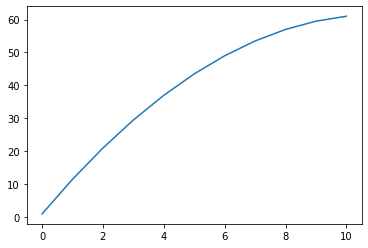

In [97]:
def u(x):
    return 1 + sum(xj*𝜙_j(x) for xj, (𝜙_j, d𝜙_j_dx) in zip(x_, polynomial_basis))

from matplotlib import pyplot as plt
plt.plot([u(x) for x in range(11)])

## A nonlinear example

We want to solve the ODE
$$ -u'' - 3k (u'²)' = f,\ u(0) = u(1) = 0.$$

The corresponding variational formulation is
$$\forall w \quad u'w' + 3k\,u'²\,v' = fv.$$

If we want the solution to be, for instance, 
$u(x) = x - x^3$, we have 
$u'(x) = 1 - 3x²$,
$u''(x) = -6x$,
$(u'²)'(x) = 2u''(x)u'(x) = -12x(1-3x²)$.


Then, we need $f(x) = -u'' - 3k (u'²)' = 6x + 36k\ x(1-3x²) = (6+36k)x - 108x²$.